In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

from glob import glob
import os
import shutil

import numpy as np
import pandas as pd
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# AIM
## To classify the images into 
### IDC+
### IDC-

# Validation Strategy:

## Train Data Size= 0.7*Total_Data
## Validation Data Size= 0.21* Total_Data
## Test Data Size= 0.09 * Total_Data

# Augmentaions Used:
## Each Image is rotated through 45 angles


In [2]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

All modules have been imported


In [3]:
sampling_seed = 0
size_4_training = 5000
img_size = 224
training_reshape=(-1, img_size, img_size, 3)
epoch_4_test = 50

In [4]:
import os
os.makedirs('../working/data/train_seg/idc-minus/')     
os.makedirs('../working/data/train_seg/idc-plus/')  
os.makedirs('../working/data/test_seg/idc-minus/')     
os.makedirs('../working/data/test_seg/idc-plus/')  
os.makedirs('../working/data/val_seg/idc-minus/')     
os.makedirs('../working/data/val_seg/idc-plus/') 

In [5]:

import random
from glob import glob
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
train_dir='../working/data/train_seg/'
validation_dir='../working/data/val_seg/'
#train_dir='../working/data/train_seg/'  
#test_dir = '../working/data/test_seg/normal'  
test_dir = '../working/data/test_seg/'  

class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model

random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class0label=np.zeros(size_4_training)
class1sample=random.sample(class1,size_4_training)
class1label=np.ones(size_4_training)

class0sample_train, class0sample_test1, class0label_train, class0label_test1 = train_test_split(class0sample, class0label, test_size=0.3, random_state=42)
class0sample_val, class0sample_test,  class0label_val, class0label_test = train_test_split(class0sample_test1, class0label_test1, test_size=0.3, random_state=42)
print(len(class0sample_train))
print(len(class0sample_test))
print(len(class0sample_val))
class1sample_train, class1sample_test1, class1label_train, class1label_test1 = train_test_split(class1sample, class1label, test_size=0.3, random_state=42)
class1sample_val, class1sample_test, class1label_val, class1label_test = train_test_split(class1sample_test1, class1label_test1, test_size=0.3, random_state=42)
print(len(class1sample_train))
print(len(class1sample_test))
print(len(class1sample_val))
def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
          
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            #print(outputname)

            shutil.copy(i, outputname)
             
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
   
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
class0val_path='../working/data/val_seg/idc-minus/'
class1val_path='../working/data/val_seg/idc-plus/'

read_and_save_data(class0train_path,class0sample_train)
read_and_save_data(class1train_path,class1sample_train)


read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)


read_and_save_data(class0val_path,class0sample_val)
read_and_save_data(class1val_path,class1sample_val)

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

In [6]:



import os #Operating System
import sys #System
import cv2
def readImage(path, tag):
    j=0
    image_data = []
    label=[]
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
        image_data.append(img_resized)
        label.append(tag)
        #print(img[1])
        j=j+1
        #if j==10:
        #    break
        
    return image_data, label

import numpy as np
from tensorflow.keras.utils import *
from sklearn.utils import shuffle

class0_train, train0_label = readImage(class0train_path, 0)
class1_train, train1_label  = readImage(class1train_path, 1)
class0_test, test0_label = readImage(class0test_path, 0)
class1_test, test1_label = readImage(class1test_path, 1)
class0_val, val0_label = readImage(class0val_path, 0)
class1_val, val1_label = readImage(class1val_path, 1)

def Image_array_process(class0array,label0, class1array, label1):
    class0_array=np.array(class0array)
    class1_array=np.array(class1array)
    combined_data = np.concatenate((class0_array, class1_array))
    combined_label= np.concatenate((label0,label1), axis=0)
    assert len(combined_data) == len(combined_label)
    combined_data, combined_label = shuffle(combined_data, combined_label, random_state=0)
    print(combined_data.shape)
    length=len(combined_data)
    combined_label=to_categorical(combined_label,num_classes=2)
    i=0
    for i in range(length):
        print(combined_label[i])

    print

    #print(class0_array.shape)
    #print(combined_data.shape)
    '''
    training_reshape=(224,224,3)
    length=len(combined_data)
    print(length)
    x =[None]*length
    #print(img_data.type)
    y =np.zeros(length)
    i=0
   
    for features,label in combined_data:
        x[i]=features
        #print(x.shape)
        y[i]=label
        #print(y[i])
        i=i+1
    
            #x = np.array(x).reshape(training_reshape)
    x = np.array(x)    
    #print(x.shape)
    #y=np.array(y)
    y=y.astype(int)
    y = to_categorical(y)
    print(y)
    '''  
    return combined_data, combined_label


X_train, y_train=Image_array_process(class0_train, train0_label, class1_train, train1_label)
X_test, y_test=Image_array_process(class0_test, test0_label, class1_test, test1_label)
X_val, y_val=Image_array_process(class0_val, val0_label, class1_val, val1_label)

(7000, 224, 224, 3)
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 

Image labelling

#import image

# Model configure

In [7]:
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'sigmoid'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 10
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


# fix pretrained layers for deep fea
from tensorflow.keras.applications import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4096,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation='sigmoid'))
#model = Model(inputs=resnet50_base_model.input, outputs=predictions)
model.summary()


2022-05-28 18:44:54.799074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 18:44:54.804255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 18:44:54.804943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 18:44:54.806014: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50176)             200704    
_________________________________________________________________
dense (Dense)                (None, 4096)              205524992 
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________

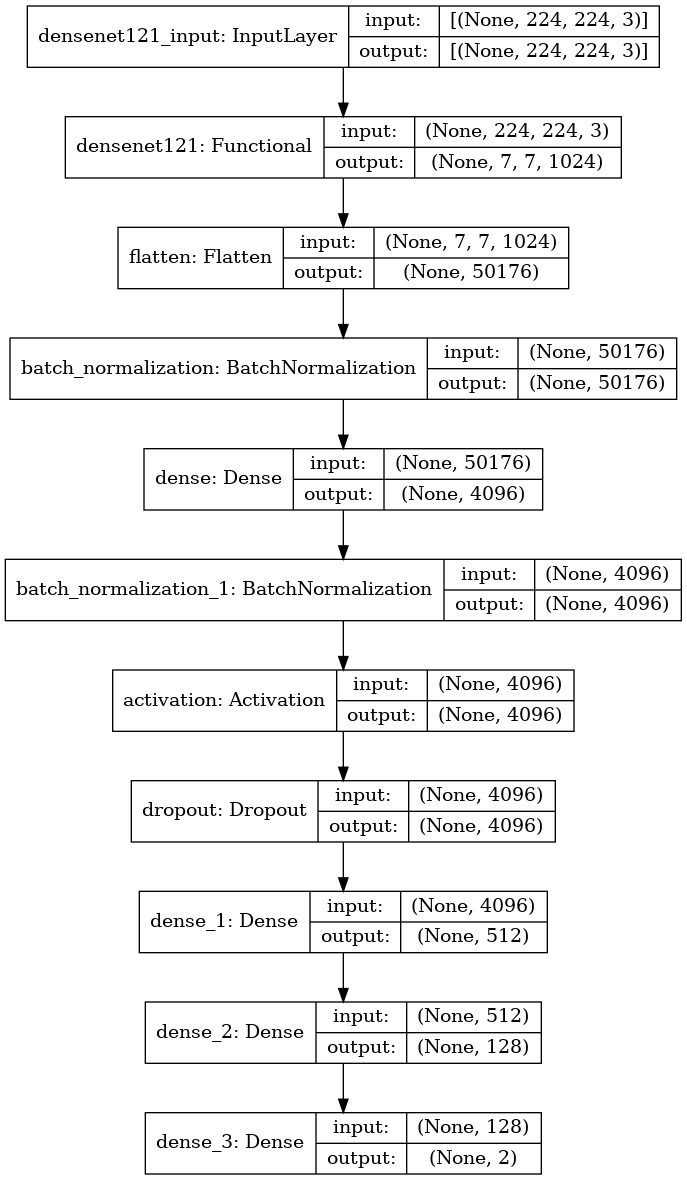

In [8]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png') 

In [9]:
# os.makedirs('../working/log/')
MODEL_INIT = '../working/init_model.h5'
MODEL_PATH = '../working/test_model.h5'

In [10]:
callbacks1 = [EarlyStopping(monitor='val_acc', patience=5, verbose=1), ModelCheckpoint(MODEL_INIT, monitor='val_accuracy', save_best_only=True)]
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [11]:
%time
history1=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 30,callbacks=callbacks1)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs


2022-05-28 18:45:02.458536: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.
2022-05-28 18:45:03.535221: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.
2022-05-28 18:45:04.335741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-28 18:45:10.849955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


219/219 [==============================] - 32s 92ms/step - loss: 0.4907 - accuracy: 0.7929 - val_loss: 0.5518 - val_accuracy: 0.7433


2022-05-28 18:45:37.016057: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.
2022-05-28 18:45:39.411203: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.
2022-05-28 18:45:41.028362: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.


Epoch 2/30
219/219 [==============================] - 19s 85ms/step - loss: 0.3945 - accuracy: 0.8356 - val_loss: 0.4310 - val_accuracy: 0.8056
Epoch 3/30
219/219 [==============================] - 17s 80ms/step - loss: 0.3406 - accuracy: 0.8551 - val_loss: 0.4350 - val_accuracy: 0.8056
Epoch 4/30
219/219 [==============================] - 17s 79ms/step - loss: 0.2846 - accuracy: 0.8844 - val_loss: 0.4470 - val_accuracy: 0.8178
Epoch 5/30
219/219 [==============================] - 17s 80ms/step - loss: 0.2366 - accuracy: 0.9036 - val_loss: 0.4704 - val_accuracy: 0.8211
Epoch 6/30
219/219 [==============================] - 17s 79ms/step - loss: 0.2027 - accuracy: 0.9154 - val_loss: 0.5265 - val_accuracy: 0.8167
Epoch 7/30
219/219 [==============================] - 18s 84ms/step - loss: 0.1636 - accuracy: 0.9360 - val_loss: 0.6014 - val_accuracy: 0.7867
Epoch 8/30
219/219 [==============================] - 18s 84ms/step - loss: 0.1488 - accuracy: 0.9387 - val_loss: 0.5881 - val_accuracy:

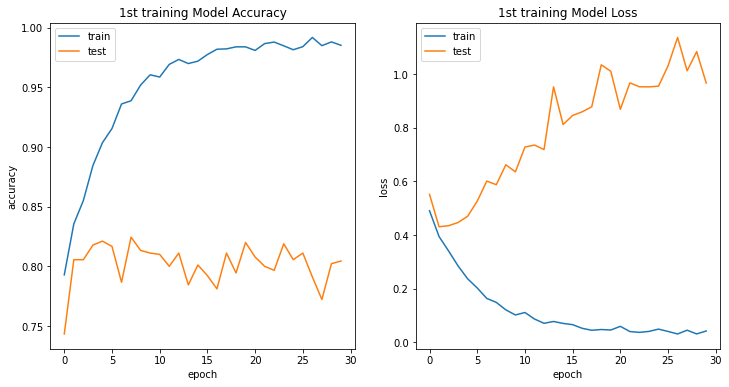

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
plt.subplot(121)
#plotting the Accuracy of test and training sets
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('1st training Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
#plotting the loss of test and training sets
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('1st training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [14]:
from keras.models import load_model

model = load_model(MODEL_INIT, compile=False)

In [15]:
opt = Adam(learning_rate=0.0001)
loss='categorical_crossentropy'
model.compile(opt, loss)
model.evaluate(X_val, y_val)

66/66 [==============================] - 6s 62ms/step - loss: 0.6818


0.6817512512207031

In [16]:
model.evaluate(X_test, y_test)

29/29 [==============================] - 2s 55ms/step - loss: 0.5881


0.5880608558654785

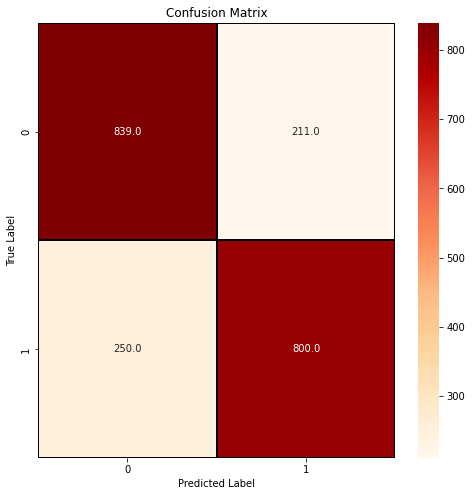

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1050
           1       0.79      0.76      0.78      1050

    accuracy                           0.78      2100
   macro avg       0.78      0.78      0.78      2100
weighted avg       0.78      0.78      0.78      2100



In [19]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # y_train=np.argmax(y_train, axis=1)
    y_test=np.argmax(y_test, axis=1)
    y_val=np.argmax(y_val, axis=1)
    #y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    #ps:all the Y value must turn back to 1 dimension array. otherwise, the scoring functions in sklearn cannot compare, and will give an error
    #classification metrics can't handle a mix of continuous-multioutput and multi-label-indicator targets
    
   # print("Train accuracy Score------------>")
   # print ("{0:.3f}".format(accuracy_score(y_train, y_train_pred)*100), "%")
    
    print("Val accuracy Score--------->")
    
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
  
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

Val accuracy Score--------->
78.048 %
Test accuracy Score--------->
82.444 %
F1 Score--------------->
82.444 %
Cohen Kappa Score------------->
64.889 %
Recall-------------->
82.444 %
Precision-------------->
82.447 %


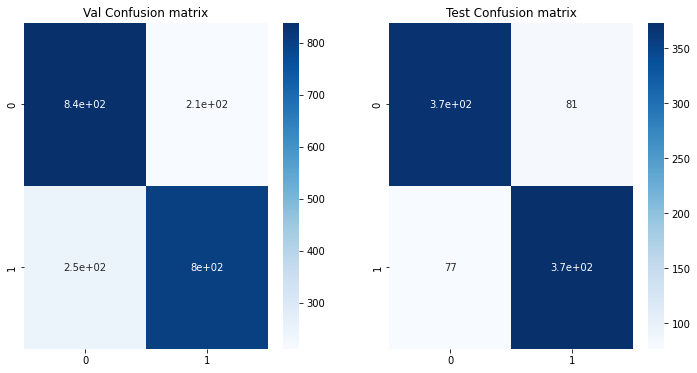

In [20]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)

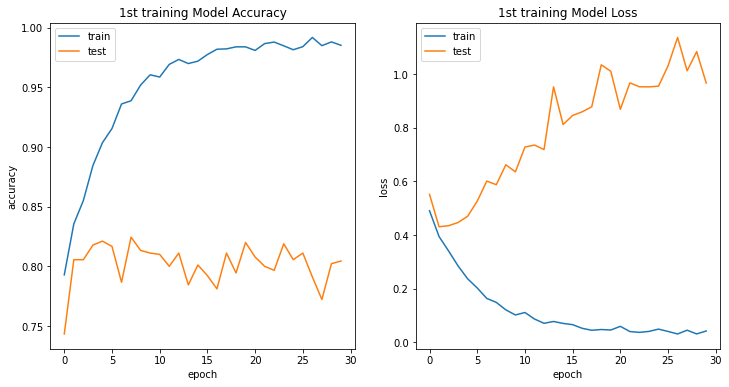

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
plt.subplot(121)
#plotting the Accuracy of test and training sets
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('1st training Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
#plotting the loss of test and training sets
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('1st training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Second Training Fine Tune

In [22]:
for model1 in model.layers:
    model1.trainable = True

In [23]:
callbacks2 = [EarlyStopping(monitor='val_acc', patience=5, verbose=1), 
              ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True)]
opt = Adam(learning_rate=0.0001)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [24]:
# model.load_weights("model.hdf5")
history2 = model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 30, callbacks=callbacks2)

Epoch 1/30
219/219 [==============================] - 23s 80ms/step - loss: 0.1565 - val_loss: 0.6183
Epoch 2/30
219/219 [==============================] - 17s 80ms/step - loss: 0.1463 - val_loss: 0.6617
Epoch 3/30
219/219 [==============================] - 17s 80ms/step - loss: 0.1083 - val_loss: 0.7140
Epoch 4/30
219/219 [==============================] - 18s 84ms/step - loss: 0.0930 - val_loss: 0.7582
Epoch 5/30
219/219 [==============================] - 18s 80ms/step - loss: 0.0899 - val_loss: 0.7956
Epoch 6/30
219/219 [==============================] - 18s 84ms/step - loss: 0.0724 - val_loss: 0.7447
Epoch 7/30
219/219 [==============================] - 18s 81ms/step - loss: 0.0696 - val_loss: 0.7876
Epoch 8/30
219/219 [==============================] - 17s 80ms/step - loss: 0.0643 - val_loss: 0.8666
Epoch 9/30
219/219 [==============================] - 18s 81ms/step - loss: 0.0579 - val_loss: 0.9199
Epoch 10/30
219/219 [==============================] - 17s 80ms/step - loss: 0.067

In [25]:
# model.load_weights("model.hdf5")
history2 = model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 15, callbacks=callbacks2)

Epoch 1/15
219/219 [==============================] - 18s 81ms/step - loss: 0.0191 - val_loss: 1.1294
Epoch 2/15
219/219 [==============================] - 19s 85ms/step - loss: 0.0346 - val_loss: 1.1082
Epoch 3/15
219/219 [==============================] - 17s 79ms/step - loss: 0.0306 - val_loss: 1.1211
Epoch 4/15
219/219 [==============================] - 18s 80ms/step - loss: 0.0169 - val_loss: 1.2485
Epoch 5/15
219/219 [==============================] - 17s 79ms/step - loss: 0.0089 - val_loss: 1.2580
Epoch 6/15
219/219 [==============================] - 19s 85ms/step - loss: 0.0251 - val_loss: 1.1381
Epoch 7/15
219/219 [==============================] - 19s 85ms/step - loss: 0.0285 - val_loss: 1.1199
Epoch 8/15
219/219 [==============================] - 17s 80ms/step - loss: 0.0210 - val_loss: 1.1645
Epoch 9/15
219/219 [==============================] - 18s 81ms/step - loss: 0.0221 - val_loss: 1.1351
Epoch 10/15
219/219 [==============================] - 17s 79ms/step - loss: 0.033

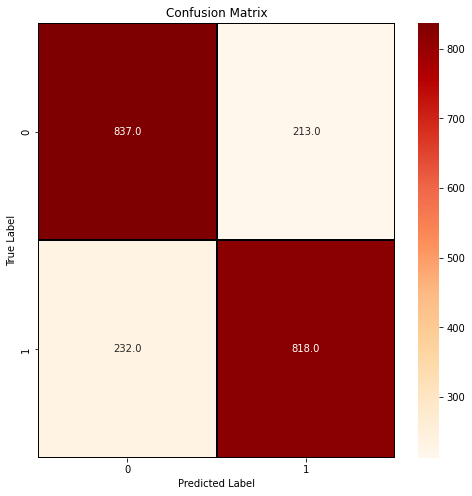

In [26]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [27]:
#model.evaluate(X_val, y_val)

In [28]:
#model.evaluate(X_test, y_test, metrics=[tf.keras.metrics.BinaryAccuracy(),
#                       tf.keras.metrics.FalseNegatives()])

In [29]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1050
           1       0.79      0.78      0.79      1050

    accuracy                           0.79      2100
   macro avg       0.79      0.79      0.79      2100
weighted avg       0.79      0.79      0.79      2100



Val accuracy Score--------->
78.810 %
Test accuracy Score--------->
81.556 %
F1 Score--------------->
81.555 %
Cohen Kappa Score------------->
63.111 %
Recall-------------->
81.556 %
Precision-------------->
81.556 %


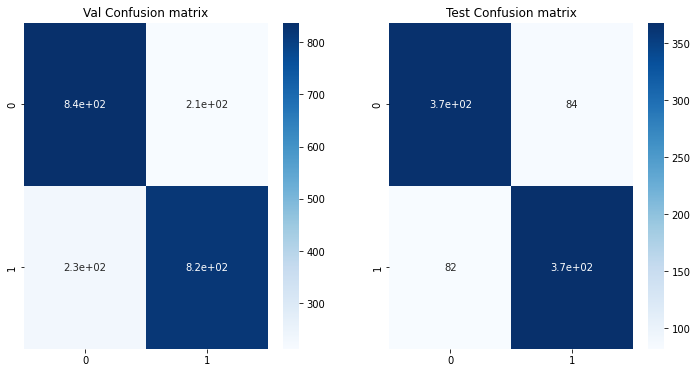

In [30]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)